In [1]:
import os
import torch
import gc
from PIL import Image
from typing import Optional, List, Dict, Any, Tuple, Union
from diffusers import QwenImageEditPlusPipeline
from diffusers.models.modeling_outputs import Transformer2DModelOutput
from diffusers.utils import USE_PEFT_BACKEND, scale_lora_layers, unscale_lora_layers
from datetime import datetime


# Clear memory
gc.collect()
torch.cuda.empty_cache()

os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "0"

# --- LeMiCa FORWARD FUNCTION ---
def LeMiCa_forward(
    self,
    hidden_states: torch.Tensor,
    encoder_hidden_states: torch.Tensor = None,
    encoder_hidden_states_mask: torch.Tensor = None,
    timestep: torch.LongTensor = None,
    img_shapes: Optional[List[Tuple[int, int, int]]] = None,
    txt_seq_lens: Optional[List[int]] = None,
    guidance: torch.Tensor = None,
    attention_kwargs: Optional[Dict[str, Any]] = None,
    controlnet_block_samples = None,
    return_dict: bool = True,
) -> Union[torch.Tensor, Transformer2DModelOutput]:

    if attention_kwargs is not None:
        attention_kwargs = attention_kwargs.copy()
        lora_scale = attention_kwargs.pop("scale", 1.0)
    else:
        lora_scale = 1.0

    if USE_PEFT_BACKEND:
        scale_lora_layers(self, lora_scale)

    hidden_states = self.img_in(hidden_states)
    timestep = timestep.to(hidden_states.dtype)
    encoder_hidden_states = self.txt_norm(encoder_hidden_states)
    encoder_hidden_states = self.txt_in(encoder_hidden_states)

    if guidance is not None:
        guidance = guidance.to(hidden_states.dtype) * 1000

    temb = (
        self.time_text_embed(timestep, hidden_states)
        if guidance is None
        else self.time_text_embed(timestep, guidance, hidden_states)
    )

    image_rotary_emb = self.pos_embed(img_shapes, txt_seq_lens, device=hidden_states.device)
    cache_device = hidden_states.device

    is_positive_prompt = (self.pair_cnt % 2 == 0)
    cache_key = 'positive' if is_positive_prompt else 'negative'
    self.pair_cnt += 1

    if not hasattr(self, 'lexcache_states'):
        self.lexcache_states = {
            'positive': {'previous_encoder_residual': None, 'previous_hidden_residual': None},
            'negative': {'previous_encoder_residual': None, 'previous_hidden_residual': None}
        }

    cache_state = self.lexcache_states[cache_key]
    should_calc = self.should_calc_list[self.cnt]
    
    if cache_key == 'negative':
        self.cnt += 1
        if self.cnt >= self.num_steps:
            self.cnt = 0
            self.pair_cnt = 0

    if not self.enable_cache:
        should_calc = True

    if not should_calc:
        if (cache_state['previous_encoder_residual'] is not None and 
            cache_state['previous_hidden_residual'] is not None):
            if (cache_state['previous_encoder_residual'].shape == encoder_hidden_states.shape and 
                cache_state['previous_hidden_residual'].shape == hidden_states.shape):
                encoder_hidden_states = encoder_hidden_states + cache_state['previous_encoder_residual'].to(encoder_hidden_states.device)
                hidden_states = hidden_states + cache_state['previous_hidden_residual'].to(hidden_states.device)
            else:
                should_calc = True
        else:
            should_calc = True

    if should_calc:
        ori_encoder_hidden_states = encoder_hidden_states.clone()
        ori_hidden_states = hidden_states.clone()

        for block in self.transformer_blocks:
            encoder_hidden_states, hidden_states = block(
                hidden_states=hidden_states,
                encoder_hidden_states=encoder_hidden_states,
                encoder_hidden_states_mask=encoder_hidden_states_mask,
                temb=temb,
                image_rotary_emb=image_rotary_emb,
            )

        cache_state['previous_encoder_residual'] = (encoder_hidden_states - ori_encoder_hidden_states).to(cache_device)
        cache_state['previous_hidden_residual'] = (hidden_states - ori_hidden_states).to(cache_device)

    hidden_states = self.norm_out(hidden_states, temb)
    output = self.proj_out(hidden_states)

    if USE_PEFT_BACKEND:
        unscale_lora_layers(self, lora_scale)

    if not return_dict:
        return (output,)

    return Transformer2DModelOutput(sample=output)


# --- LOAD MODEL ---
print("🔥 Loading Model...")

pipeline = QwenImageEditPlusPipeline.from_pretrained(
    "Qwen/Qwen-Image-Edit-2509",
    torch_dtype=torch.bfloat16,
)
pipeline.to("cuda")

# --- SETUP LeMiCa CACHE ---
# Speed presets for 30 steps (adjust indices for your step count)
SPEED_PRESETS = {
    "off": list(range(30)),  # All steps calculated (no cache)
    "slow": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 18, 21, 24, 27, 29],  # ~19 steps
    "medium": [0, 1, 2, 3, 4, 5, 6, 9, 12, 18, 24, 29],  # ~12 steps  
    "fast": [0, 1, 3, 6, 12, 20, 29],  # ~7 steps
}

NUM_STEPS = 30

def set_cache_mode(mode: str = "medium"):
    """Set LeMiCa cache mode: 'off', 'slow', 'medium', 'fast'"""
    global CURRENT_CACHE_MODE
    CURRENT_CACHE_MODE = mode
    
    # Apply LeMiCa forward
    pipeline.transformer.__class__.forward = LeMiCa_forward
    
    # Setup cache parameters
    pipeline.transformer.enable_cache = (mode != "off")
    pipeline.transformer.cnt = 0
    pipeline.transformer.pair_cnt = 0
    pipeline.transformer.num_steps = NUM_STEPS
    
    steps = SPEED_PRESETS.get(mode, SPEED_PRESETS["medium"])
    pipeline.transformer.should_calc_list = [(i in steps) for i in range(NUM_STEPS)]
    
    # Clear previous cache
    if hasattr(pipeline.transformer, 'lexcache_states'):
        del pipeline.transformer.lexcache_states
    
    print(f"⚡ LeMiCa mode: {mode} ({len(steps)}/{NUM_STEPS} steps calculated)")

# Set default cache mode
set_cache_mode("fast")

pipeline.set_progress_bar_config(disable=False)

print("✅ Model Ready with LeMiCa!")
print(f"📊 GPU Memory: {torch.cuda.memory_allocated()/1e9:.1f}GB / {torch.cuda.get_device_properties(0).total_memory/1e9:.1f}GB")

🔥 Loading Model...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

⚡ LeMiCa mode: fast (7/30 steps calculated)
✅ Model Ready with LeMiCa!
📊 GPU Memory: 57.8GB / 85.1GB



🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨
   WEDDING TABLE STYLING PIPELINE
   (8 Place Settings)
🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨

📁 Run: run4_fast_steps20_size768_torchOff
📝 Notes: 8 place settings explicit - fast cache
🔧 Settings: steps=25, seed=42, size=768, cache=fast
📊 Pipeline: 7 steps
💾 Output: /workspace/images/output/run4_fast_steps20_size768_torchOff

💾 Original saved: /workspace/images/output/run4_fast_steps20_size768_torchOff/step_0_original.png
⚡ LeMiCa mode: fast (7/25 steps calculated)

🔄 STEP 1: CHAIRS
📷 Base: (768, 615) | Ref: (298, 314)
📁 Ref image: chairs/clear_chiavari.png


guidance_scale is passed as 1.0, but ignored since the model is not guidance-distilled.


  0%|          | 0/25 [00:00<?, ?it/s]

✅ Done in 21.0s
💾 Saved: /workspace/images/output/run4_fast_steps20_size768_torchOff/step_1_chairs.png
⚡ LeMiCa mode: fast (7/25 steps calculated)

🔄 STEP 2: TABLECLOTH
📷 Base: (721, 768) | Ref: (298, 314)
📁 Ref image: tablecloths/satin_red.png


guidance_scale is passed as 1.0, but ignored since the model is not guidance-distilled.


  0%|          | 0/25 [00:00<?, ?it/s]

✅ Done in 21.0s
💾 Saved: /workspace/images/output/run4_fast_steps20_size768_torchOff/step_2_tablecloth.png
⚡ LeMiCa mode: fast (7/25 steps calculated)

🔄 STEP 3: PLATES
📷 Base: (721, 768) | Ref: (328, 312)
📁 Ref image: plates/white_with_gold_rim.png


guidance_scale is passed as 1.0, but ignored since the model is not guidance-distilled.


  0%|          | 0/25 [00:00<?, ?it/s]

✅ Done in 21.0s
💾 Saved: /workspace/images/output/run4_fast_steps20_size768_torchOff/step_3_plates.png
⚡ LeMiCa mode: fast (7/25 steps calculated)

🔄 STEP 4: NAPKINS
📷 Base: (768, 721) | Ref: (328, 312)
📁 Ref image: napkins/satin_pink.png


guidance_scale is passed as 1.0, but ignored since the model is not guidance-distilled.


  0%|          | 0/25 [00:00<?, ?it/s]

✅ Done in 21.1s
💾 Saved: /workspace/images/output/run4_fast_steps20_size768_torchOff/step_4_napkins.png
⚡ LeMiCa mode: fast (7/25 steps calculated)

🔄 STEP 5: CUTLERY
📷 Base: (768, 721) | Ref: (328, 312)
📁 Ref image: cutlery/gold_luxe.png


guidance_scale is passed as 1.0, but ignored since the model is not guidance-distilled.


  0%|          | 0/25 [00:00<?, ?it/s]

✅ Done in 21.1s
💾 Saved: /workspace/images/output/run4_fast_steps20_size768_torchOff/step_5_cutlery.png
⚡ LeMiCa mode: fast (7/25 steps calculated)

🔄 STEP 6: GLASSWARE
📷 Base: (768, 721) | Ref: (258, 350)
📁 Ref image: glassware/crystal_wine_glass.png


guidance_scale is passed as 1.0, but ignored since the model is not guidance-distilled.


  0%|          | 0/25 [00:00<?, ?it/s]

✅ Done in 20.8s
💾 Saved: /workspace/images/output/run4_fast_steps20_size768_torchOff/step_6_glassware.png
⚡ LeMiCa mode: fast (7/25 steps calculated)

🔄 STEP 7: CENTERPIECE
📷 Base: (560, 768) | Ref: (328, 312)
📁 Ref image: centerpieces/pink_flowral_with_gold_stand.png


guidance_scale is passed as 1.0, but ignored since the model is not guidance-distilled.


  0%|          | 0/25 [00:00<?, ?it/s]

✅ Done in 21.0s
💾 Saved: /workspace/images/output/run4_fast_steps20_size768_torchOff/step_7_centerpiece.png
📄 Config saved: /workspace/images/output/run4_fast_steps20_size768_torchOff/run_config.txt

📊 PIPELINE SUMMARY
Run: run4_fast_steps20_size768_torchOff
Settings: steps=25, seed=42, cache=fast
----------------------------------------
   chairs            21.0s
   tablecloth        21.0s
   plates            21.0s
   napkins           21.1s
   cutlery           21.1s
   glassware         20.8s
   centerpiece       21.0s
----------------------------------------
   TOTAL            149.4s
   AVG/STEP          21.3s

🏁 Final result: /workspace/images/output/run4_fast_steps20_size768_torchOff/final_result.png


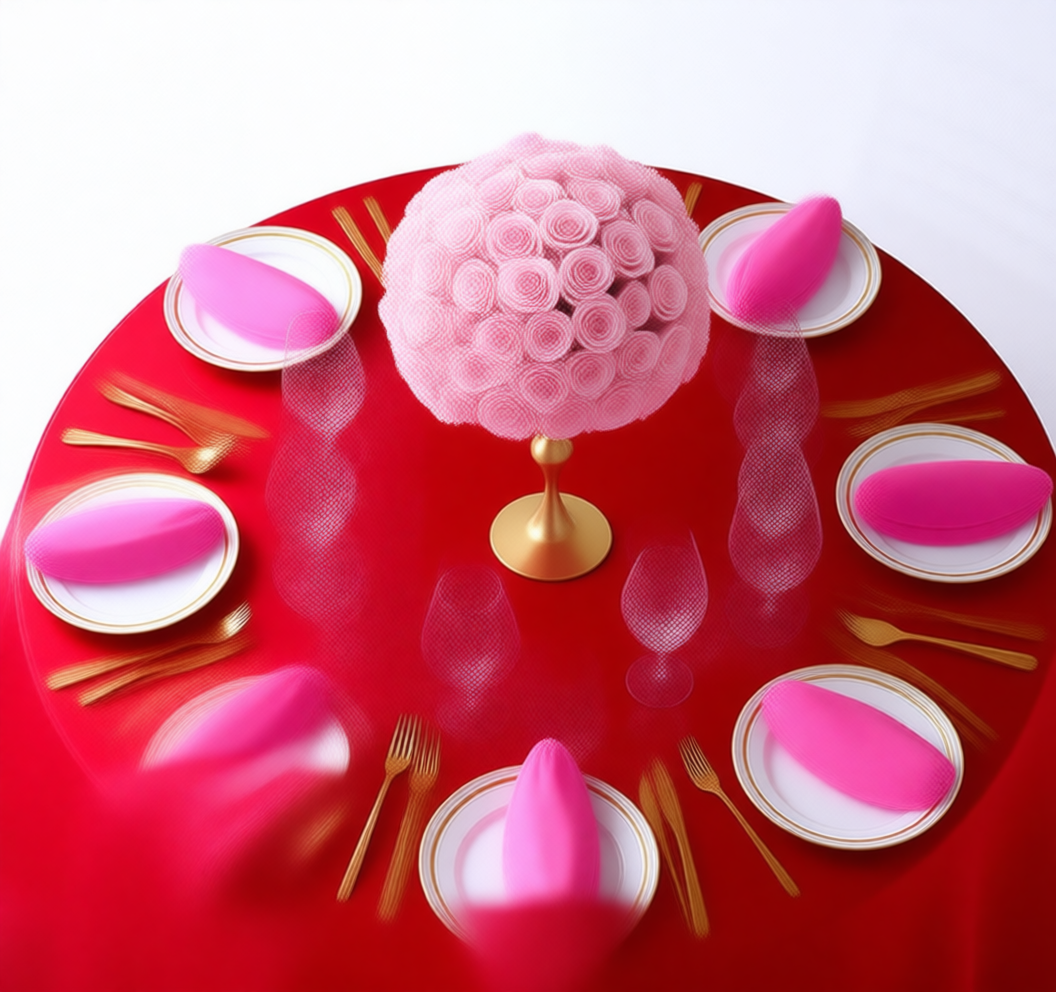

In [3]:
import time
import os
from PIL import Image
import torch
from datetime import datetime

# =============================================================================
# RUN CONFIGURATION
# =============================================================================

RUN_NAME = "run4_fast_steps20_size768_torchOff"  # Change this for each test run!
RUN_NOTES = "8 place settings explicit - fast cache"

# =============================================================================
# PATHS
# =============================================================================

INPUT_DIR = "/workspace/images"
OUTPUT_DIR = f"/workspace/images/output/{RUN_NAME}"
BASE_IMAGE = "base_image_table.png"

# =============================================================================
# GENERATION SETTINGS
# =============================================================================

NUM_STEPS = 25
SEED = 42
MAX_SIZE = 768
CACHE_MODE = "fast"  # "off", "slow", "medium", "fast"
# pipeline.transformer = torch.compile(pipeline.transformer, mode="reduce-overhead")

# =============================================================================
# PIPELINE STEPS - Full 7-step table styling workflow (8 place settings)
# =============================================================================

PIPELINE_STEPS = [
    # STEP 1: CHAIRS
    {
        "name": "chairs",
        "ref_image": "chairs/clear_chiavari.png",
        "prompt": """Task: Replace ONLY the 8 chairs in this wedding table scene.
Reference: Clear chiavari chair.

CRITICAL INSTRUCTIONS:
- Replace all 8 existing chairs with clear chiavari chairs matching the reference image exactly.
- Maintain the same positions around the table - 8 chairs total, evenly spaced.
- Match lighting, shadows, and perspective to the scene.

DO NOT MODIFY: The table, tablecloth, and any items on the table must remain EXACTLY as shown in the base image. No additions, no changes, no removals except the 8 chairs.

Output: Photorealistic, high-resolution photograph.""",
    },
    
    # STEP 2: TABLECLOTH
    {
        "name": "tablecloth",
        "ref_image": "tablecloths/satin_red.png",
        "prompt": """Task: Replace ONLY the tablecloth in this wedding table scene.
Reference: Red satin tablecloth.

CRITICAL INSTRUCTIONS:
- Replace the tablecloth with a luxurious red satin tablecloth matching the reference image.
- Ensure natural fabric draping with realistic folds and sheen.
- Match lighting and shadows to the scene.

DO NOT MODIFY: The 8 clear chiavari chairs must remain EXACTLY as shown - same positions, same style, same appearance. Do not change or remove any chairs.

Output: Photorealistic, high-resolution photograph.""",
    },
    
    # STEP 3: PLATES
    {
        "name": "plates",
        "ref_image": "plates/white_with_gold_rim.png",
        "prompt": """Task: Add ONLY plates to this wedding table scene.
Reference: White plate with elegant gold rim.

CRITICAL INSTRUCTIONS:
- Add exactly 8 white plates with gold rim (matching reference) - one at each place setting.
- Position each plate centered in front of each of the 8 chairs.
- Match lighting, shadows, and perspective perfectly.
- All 8 plates should be identical in style and size.

DO NOT MODIFY: The 8 clear chiavari chairs and red satin tablecloth must remain EXACTLY as shown in the base image. Do not add any other items.

Output: Photorealistic, high-resolution photograph.""",
    },
    
    # STEP 4: NAPKINS
    {
        "name": "napkins",
        "ref_image": "napkins/satin_pink.png",
        "prompt": """Task: Add ONLY napkins to this wedding table scene.
Reference: Pink satin napkin.

CRITICAL INSTRUCTIONS:
- Add exactly 8 elegantly folded pink satin napkins (matching reference) - one at each place setting.
- Position each napkin on top of or beside each of the 8 plates in a decorative fold.
- Match lighting, shadows, and perspective perfectly.
- All 8 napkins should be folded identically.

DO NOT MODIFY: The following must remain EXACTLY as shown in the base image:
- 8 clear chiavari chairs (same positions, style unchanged)
- Red satin tablecloth (color, draping unchanged)
- 8 white plates with gold rim (same positions, style unchanged)
Do not add any other items.

Output: Photorealistic, high-resolution photograph.""",
    },
    
    # STEP 5: CUTLERY
    {
        "name": "cutlery",
        "ref_image": "cutlery/gold_luxe.png",
        "prompt": """Task: Add ONLY cutlery to this wedding table scene.
Reference: Gold luxe cutlery set.

CRITICAL INSTRUCTIONS:
- Add exactly 8 complete gold cutlery sets (matching reference) - one set at each place setting.
- Position fork on left of plate, knife and spoon on right (formal setting) for all 8 settings.
- Match lighting, shadows, and perspective perfectly.
- All 8 cutlery sets should be positioned identically relative to their plates.

DO NOT MODIFY: The following must remain EXACTLY as shown in the base image:
- 8 clear chiavari chairs (same positions, style unchanged)
- Red satin tablecloth (color, draping unchanged)
- 8 white plates with gold rim (same positions, style unchanged)
- 8 pink satin napkins (same positions, folds unchanged)
Do not add any other items.

Output: Photorealistic, high-resolution photograph.""",
    },
    
    # STEP 6: GLASSWARE
    {
        "name": "glassware",
        "ref_image": "glassware/crystal_wine_glass.png",
        "prompt": """Task: Add ONLY glassware to this wedding table scene.
Reference: Crystal wine glass.

CRITICAL INSTRUCTIONS:
- Add exactly 8 crystal wine glasses (matching reference) - one at each place setting.
- Position each glass at the top right of each plate, slightly above the knife.
- All glasses must appear transparent with realistic light refraction.
- Match lighting, shadows, reflections, and perspective perfectly.
- All 8 glasses should be positioned identically relative to their place settings.

DO NOT MODIFY: The following must remain EXACTLY as shown in the base image:
- 8 clear chiavari chairs (same positions, style unchanged)
- Red satin tablecloth (color, draping unchanged)
- 8 white plates with gold rim (same positions, style unchanged)
- 8 pink satin napkins (same positions, folds unchanged)
- 8 gold cutlery sets (same positions, style unchanged)
Do not add any other items.

Output: Photorealistic, high-resolution photograph.""",
    },
    
    # STEP 7: CENTERPIECE
    {
        "name": "centerpiece",
        "ref_image": "centerpieces/pink_flowral_with_gold_stand.png",
        "prompt": """Task: Add ONLY a centerpiece to this wedding table scene.
Reference: Pink floral arrangement with gold stand.

CRITICAL INSTRUCTIONS:
- Add exactly 1 pink floral centerpiece with gold stand (matching reference) to the center of the table.
- Position prominently in the middle of the table as the focal point.
- Flowers should appear fresh and vibrant, complementing the pink napkins and gold accents.
- Match lighting, shadows, and perspective perfectly.

DO NOT MODIFY: The following must remain EXACTLY as shown in the base image:
- 8 clear chiavari chairs (same positions, style unchanged)
- Red satin tablecloth (color, draping unchanged)
- 8 white plates with gold rim (same positions, style unchanged)
- 8 pink satin napkins (same positions, folds unchanged)
- 8 gold cutlery sets (same positions, style unchanged)
- 8 crystal wine glasses (same positions, style unchanged)
Do not add any other items except the single centerpiece.

Output: Photorealistic, high-resolution photograph of a complete wedding reception table for 8 guests.""",
    },
]

# =============================================================================
# HELPER FUNCTIONS
# =============================================================================

def resize(img, max_side=MAX_SIZE):
    """Resize image maintaining aspect ratio"""
    w, h = img.size
    if max(w, h) <= max_side:
        return img
    ratio = max_side / max(w, h)
    return img.resize((int(w * ratio), int(h * ratio)), Image.LANCZOS)


def save_run_config(output_dir: str, total_time: float, step_times: list):
    """Save run configuration and results to a text file"""
    config_path = os.path.join(output_dir, "run_config.txt")
    with open(config_path, "w") as f:
        f.write(f"{'='*60}\n")
        f.write(f"RUN: {RUN_NAME}\n")
        f.write(f"{'='*60}\n\n")
        f.write(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Notes: {RUN_NOTES}\n\n")
        f.write(f"SETTINGS:\n")
        f.write(f"  - NUM_STEPS: {NUM_STEPS}\n")
        f.write(f"  - SEED: {SEED}\n")
        f.write(f"  - MAX_SIZE: {MAX_SIZE}\n")
        f.write(f"  - CACHE_MODE: {CACHE_MODE}\n\n")
        f.write(f"PIPELINE STEPS:\n")
        for i, step in enumerate(PIPELINE_STEPS, 1):
            f.write(f"  {i}. {step['name']}: {step['ref_image']}\n")
        f.write(f"\nSTEP TIMES:\n")
        for name, t in step_times:
            f.write(f"  - {name:<15} {t:>6.1f}s\n")
        f.write(f"\nTOTAL TIME: {total_time:.1f}s\n")
        f.write(f"AVG PER STEP: {total_time/len(step_times):.1f}s\n")
    print(f"📄 Config saved: {config_path}")


def run_step(base_img: Image.Image, ref_path: str, prompt: str, step_name: str, step_num: int, output_dir: str):
    """Run a single pipeline step"""
    
    # Reset cache state for each generation
    set_cache_mode(CACHE_MODE)
    
    # Load and resize images
    ref_full_path = os.path.join(INPUT_DIR, ref_path)
    if not os.path.exists(ref_full_path):
        print(f"❌ ERROR: Reference image not found: {ref_full_path}")
        return base_img, 0
    
    ref_img = resize(Image.open(ref_full_path).convert("RGB"))
    base_img_resized = resize(base_img)
    
    print(f"\n{'='*60}")
    print(f"🔄 STEP {step_num}: {step_name.upper()}")
    print(f"{'='*60}")
    print(f"📷 Base: {base_img_resized.size} | Ref: {ref_img.size}")
    print(f"📁 Ref image: {ref_path}")
    
    torch.cuda.synchronize()
    start_time = time.time()
    
    with torch.inference_mode():
        output = pipeline(
            image=[base_img_resized, ref_img],
            prompt=prompt,
            negative_prompt="blurry, distorted, low quality, deformed, unrealistic, cartoon, painting, sketch, artifacts, wrong number of items, missing items, extra items, changed elements, modified chairs, different tablecloth color, moved items",
            num_inference_steps=NUM_STEPS,
            true_cfg_scale=4.0,
            guidance_scale=1.0,
            generator=torch.Generator("cuda").manual_seed(SEED + step_num)
        )
    
    torch.cuda.synchronize()
    step_time = time.time() - start_time
    
    result_img = output.images[0]
    
    # Save intermediate result
    out_path = os.path.join(output_dir, f"step_{step_num}_{step_name}.png")
    result_img.save(out_path)
    print(f"✅ Done in {step_time:.1f}s")
    print(f"💾 Saved: {out_path}")
    
    return result_img, step_time


def run_pipeline():
    """Execute the full chained pipeline"""
    
    # Create output directory for this run
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    print("\n" + "🎨" * 30)
    print("   WEDDING TABLE STYLING PIPELINE")
    print("   (8 Place Settings)")
    print("🎨" * 30)
    print(f"\n📁 Run: {RUN_NAME}")
    print(f"📝 Notes: {RUN_NOTES}")
    print(f"🔧 Settings: steps={NUM_STEPS}, seed={SEED}, size={MAX_SIZE}, cache={CACHE_MODE}")
    print(f"📊 Pipeline: {len(PIPELINE_STEPS)} steps")
    print(f"💾 Output: {OUTPUT_DIR}")
    
    # Verify base image exists
    base_path = os.path.join(INPUT_DIR, BASE_IMAGE)
    if not os.path.exists(base_path):
        print(f"❌ ERROR: Base image not found: {base_path}")
        return None
    
    # Load initial base image
    current_image = Image.open(base_path).convert("RGB")
    
    # Save a copy of the original
    original_path = os.path.join(OUTPUT_DIR, "step_0_original.png")
    resize(current_image).save(original_path)
    print(f"\n💾 Original saved: {original_path}")
    
    total_start = time.time()
    step_times = []
    
    # Run each step
    for i, step in enumerate(PIPELINE_STEPS, 1):
        current_image, step_time = run_step(
            base_img=current_image,
            ref_path=step["ref_image"],
            prompt=step["prompt"],
            step_name=step["name"],
            step_num=i,
            output_dir=OUTPUT_DIR
        )
        step_times.append((step["name"], step_time))
    
    total_time = time.time() - total_start
    
    # Save final result
    final_path = os.path.join(OUTPUT_DIR, "final_result.png")
    current_image.save(final_path)
    
    # Save run configuration
    save_run_config(OUTPUT_DIR, total_time, step_times)
    
    # Print summary
    print("\n" + "=" * 60)
    print("📊 PIPELINE SUMMARY")
    print("=" * 60)
    print(f"Run: {RUN_NAME}")
    print(f"Settings: steps={NUM_STEPS}, seed={SEED}, cache={CACHE_MODE}")
    print("-" * 40)
    for name, t in step_times:
        print(f"   {name:<15} {t:>6.1f}s")
    print("-" * 40)
    print(f"   {'TOTAL':<15} {total_time:>6.1f}s")
    print(f"   {'AVG/STEP':<15} {total_time/len(step_times):>6.1f}s")
    print(f"\n🏁 Final result: {final_path}")
    print("=" * 60)
    
    return current_image


# =============================================================================
# RUN THE PIPELINE
# =============================================================================

final_image = run_pipeline()

# Display final result in notebook
final_image